In [1]:
import numpy as np
import pandas as pd
print pd.__version__

0.19.1


In [2]:
data_dir = "data/pdaid/"
!ls $data_dir

bacterial.csv fungal.csv    parasitic.csv viral.csv


In [3]:
amino_acids = {"A": "Alanine",
            "C": "Cysteine",
            "D": "Aspartic Acid",
            "E": "Glutamic Acid",
            "F": "Phenylalanine",
            "G": "Glycine",
            "H": "Histidine",
            "I": "Isoleucine",
            "K": "Lysine",
            "L": "Leucine",
            "M": "Methionine",
            "N": "Asparagine",
            "P": "Proline",
            "Q": "Glutamine",
            "R": "Arginine",
            "S": "Serine",
            "T": "Threonine",
            "U": "Selenocysteine",
            "V": "Valine",
            "W": "Tryptophan",
            "Y": "Tyrosine"}

In [4]:
disease_groups = ["bacterial", "parasitic", "viral", "fungal"]
disease_col = "disease"
bacterial = pd.DataFrame.from_csv(data_dir + "bacterial.csv")
bacterial[disease_col] = "bacterial"
fungal = pd.DataFrame.from_csv(data_dir + "fungal.csv")
fungal[disease_col] = "fungal"
parasitic = pd.DataFrame.from_csv(data_dir + "parasitic.csv")
parasitic[disease_col] = "parasitic"
viral = pd.DataFrame.from_csv(data_dir + "viral.csv")
viral[disease_col] = "viral"
print "Input -- Bacterial: %d, Fungal: %d, Parasitic: %d, Viral: %d" % \
    (bacterial.shape[0], fungal.shape[0], parasitic.shape[0], viral.shape[0])

# Consider putting fungal back in? (only 39 samples)
all_samples = bacterial\
    .append(parasitic, ignore_index=True)\
    .append(viral, ignore_index= True)
all_samples.columns = [
        'type', 'epitope_sequence', 'start', 'end', 'chebi', 'syn', 'protein',
        'protein_id', 'organism', 'oid', 'comments', 'disease'
    ]
# Remove entries with '+' notation (note: looking into this, e.g. "PLNISLGDVVLY + DEAM(N3)")
all_samples = all_samples[all_samples.epitope_sequence.str.find('+') == -1]

seq_len = 9
# Remove epitopes less than 'seq_len' AAs long
all_samples = all_samples[all_samples.epitope_sequence.str.len() >= seq_len]
# Use 'seq_len' AAs from the C-terminus
all_samples['epitope_sequence'] = all_samples.epitope_sequence.str[-seq_len::]
all_samples = all_samples[["epitope_sequence", "disease"]]
all_samples = all_samples[all_samples.epitope_sequence.str.find("Z") == -1]
all_samples = all_samples.sort_values(by=["epitope_sequence"])
print "All filtered samples: %d" % (all_samples.shape[0])

Input -- Bacterial: 3475, Fungal: 39, Parasitic: 3444, Viral: 8066
All filtered samples: 13547


In [5]:
dup_mask = all_samples.duplicated(subset=["epitope_sequence"], keep=False)
dups = all_samples[dup_mask].sort_values(by=["epitope_sequence"])
nondups = all_samples[dup_mask == False]
print "There are %d duplicated and %d unique rows" % (dups.shape[0], nondups.shape[0])

There are 3085 duplicated and 10462 unique rows


In [6]:
from aa_props import seq_to_aa_props
from sklearn.preprocessing import MinMaxScaler
import random

y = []
X = []

for (rowid, seq, disease) in nondups.itertuples():
    valid = True
    for aa in seq:
        if not aa in amino_acids.keys():
            valid = False
            break
    if valid:
        features = seq_to_aa_props(seq)
        X.append(features)
        y.append(disease)

# Scale the data
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

ll_training_filename = "/tmp/pdaid_training.ll"
ll_testing_filename = "/tmp/pdaid_testing.ll"

with open(ll_training_filename, 'w') as ll_train:
    with open(ll_testing_filename, 'w') as ll_test:
        for (features, disease) in zip(scaled_X, y):
            if random.random() >= 0.75:
                ll_file = ll_test
            else:
                ll_file = ll_train
            ll_file.write("%d" % (disease_groups.index(disease)))
            for (i, feature) in enumerate(features):
                ll_file.write(" %d:%.12f" % (i+1, feature))
            ll_file.write("\n")

In [7]:
# Find the best C parameter for the LR model
LR_findC = !train -C -s 0 -w0 1 -w1 1 -w2 2 "$ll_training_filename"
print "\n".join(LR_findC)

Doing parameter search with 5-fold cross validation.
log2c= -21.00	rate=52.4725
log2c= -20.00	rate=52.4725
log2c= -19.00	rate=52.4725
log2c= -18.00	rate=52.4725
log2c= -17.00	rate=52.4725
log2c= -16.00	rate=52.4725
log2c= -15.00	rate=52.4725
log2c= -14.00	rate=52.4725
log2c= -13.00	rate=52.4725
log2c= -12.00	rate=53.3692
log2c= -11.00	rate=55.0602
log2c= -10.00	rate=56.0466
log2c=  -9.00	rate=57.2765
log2c=  -8.00	rate=57.6992
log2c=  -7.00	rate=58.391
log2c=  -6.00	rate=58.6344
log2c=  -5.00	rate=59.6336
log2c=  -4.00	rate=59.7489
log2c=  -3.00	rate=60.1589
log2c=  -2.00	rate=60.1589
log2c=  -1.00	rate=60.1717
log2c=   0.00	rate=60.1717
log2c=   1.00	rate=60.1717
log2c=   2.00	rate=60.1717
Best C = 0.5  CV accuracy = 60.1717%


In [8]:
# Find the best C parameter for the SVC model
SVC_findC = !train -C -s 2 -w0 1 -w1 1 -w2 2 "$ll_training_filename"
print "\n".join(SVC_findC)

Doing parameter search with 5-fold cross validation.
log2c= -22.00	rate=52.4725
log2c= -21.00	rate=52.4725
log2c= -20.00	rate=52.4725
log2c= -19.00	rate=52.4725
log2c= -18.00	rate=52.4725
log2c= -17.00	rate=52.4725
log2c= -16.00	rate=52.4725
log2c= -15.00	rate=53.4461
log2c= -14.00	rate=55.0858
log2c= -13.00	rate=55.9954
log2c= -12.00	rate=56.9434
log2c= -11.00	rate=57.5711
log2c= -10.00	rate=57.7504
log2c=  -9.00	rate=58.122
log2c=  -8.00	rate=59.0956
log2c=  -7.00	rate=59.3262
log2c=  -6.00	rate=59.3262
log2c=  -5.00	rate=59.3518
log2c=  -4.00	rate=59.339
log2c=  -3.00	rate=59.4799
log2c=  -2.00	rate=59.4799
log2c=  -1.00	rate=59.4799
log2c=   0.00	rate=59.4799
Best C = 0.125  CV accuracy = 59.4799%


In [9]:
def create_model_and_predictions(search_output, solver, model_file, predictions_file, probability_estimates, train_file, test_file):
    # Grab C from the last line...
    bestC = float(search_output[-1].split(" ")[3])
    cmd = "train -c %f -w0 1 -w1 1 -w2 2 -s %d '%s' '%s'" % (bestC, solver, train_file, model_file)
    print "> " + cmd
    createModel = !{cmd}
    print "\n".join(createModel)
    cmd = "predict -b %d '%s' '%s' '%s'" % (probability_estimates, test_file, model_file, predictions_file)
    print "> " + cmd
    predict = !{cmd}
    print "\n".join(predict)
    print "\n"

LR_model_file="/tmp/pdaid_lr.model"
SVC_model_file="/tmp/pdaid_svc.model"
LR_predictions_file = "/tmp/lr.predictions"
SVC_predictions_file = "/tmp/svc.predictions"
    
create_model_and_predictions(LR_findC, 0, LR_model_file, LR_predictions_file, 1, ll_training_filename, ll_testing_filename)
create_model_and_predictions(SVC_findC, 2, SVC_model_file, SVC_predictions_file, 0, ll_training_filename, ll_testing_filename)

> train -c 0.500000 -w0 1 -w1 1 -w2 2 -s 0 '/tmp/pdaid_training.ll' '/tmp/pdaid_lr.model'
iter  1 act 4.728e+02 pre 4.559e+02 delta 1.002e-01 f 2.705e+03 |g| 9.453e+03 CG   1
cg reaches trust region boundary
iter  2 act 2.761e+01 pre 2.731e+01 delta 2.178e-01 f 2.233e+03 |g| 7.336e+02 CG   2
cg reaches trust region boundary
iter  3 act 2.885e+01 pre 2.885e+01 delta 2.991e-01 f 2.205e+03 |g| 2.129e+02 CG   2
cg reaches trust region boundary
iter  4 act 2.497e+01 pre 2.479e+01 delta 4.329e-01 f 2.176e+03 |g| 3.599e+02 CG   2
cg reaches trust region boundary
iter  5 act 2.866e+01 pre 2.843e+01 delta 6.445e-01 f 2.151e+03 |g| 1.339e+02 CG   3
cg reaches trust region boundary
iter  6 act 1.785e+01 pre 1.738e+01 delta 6.771e-01 f 2.122e+03 |g| 9.281e+01 CG   3
cg reaches trust region boundary
iter  7 act 1.644e+01 pre 1.662e+01 delta 7.480e-01 f 2.105e+03 |g| 1.174e+02 CG   4
cg reaches trust region boundary
iter  8 act 1.057e+01 pre 1.032e+01 delta 7.712e-01 f 2.088e+03 |g| 9.381e+01 CG   5

In [10]:
import numpy as np
import pandas as pd
from math import log

def alphabet_dict():
    d = {}
    for letter in amino_acids.keys():
        d[letter] = 0
    return d

def init_counters():
    return [alphabet_dict() for i in range(seq_len)]

counters = {"bacterial": init_counters(),
            "viral": init_counters(),
            "parasitic": init_counters(),
            "fungal": init_counters(),
            "total": init_counters()}
for (rowid, seq, disease) in nondups.itertuples():
    for (i, aa) in enumerate(seq):
        counters[disease][i][aa.upper()] += 1

for i in range(seq_len):
    for aa in amino_acids.keys():
        # TODO: readd fungal values?
        counters["total"][i][aa] += (counters["bacterial"][i][aa] \
                                    + counters["viral"][i][aa]\
                                    + counters["parasitic"][i][aa])
    
def prob(disease, pos, aa):
    counter = counters[disease][pos]
    total = 0
    for count in counter.values():
        total += count
    if counter[aa] == 0:
        return 0
    else:
        return float(counter[aa])/total
    
def safe_log(x):
    if x <= 0:
        return float("-inf")
    return log(x, 2.0)

def generate_kl_heatmap(disease):
    result = [alphabet_dict() for i in range(seq_len)]
    for i in range(seq_len):
        for letter in amino_acids.keys():
            result[i][letter] = prob(disease, i, letter) * safe_log( prob(disease, i, letter) / max(0.00000001, prob("total", i, letter)))

    r = pd.DataFrame(result).transpose()
    vmin = r.min().min()
    vmax = r.max().max()
    center = (vmax - vmin)/2

    import seaborn as sns
    sns.set()
    ax = sns.heatmap(r, linewidths=.5,
            yticklabels=["%s (%s)" % (amino_acids[code], code) for code in r.index],
            xticklabels=["%d" %(i) for i in range(seq_len)], 
            vmin=vmin, vmax=vmax, center=center, cmap="YlGnBu", alpha=0.8)
    ax.set_title('%s Kullback-Leibler Information, $I(i) = \sum_{L=0}^{N}p_{i}^{L}\log_2(p_{i}^{L}/q_{i}^{L})$' % (disease))

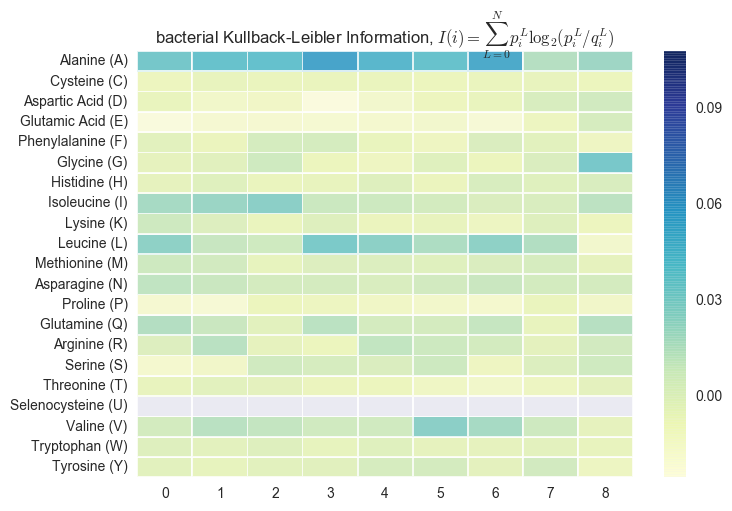

In [11]:
%matplotlib inline
generate_kl_heatmap("bacterial")

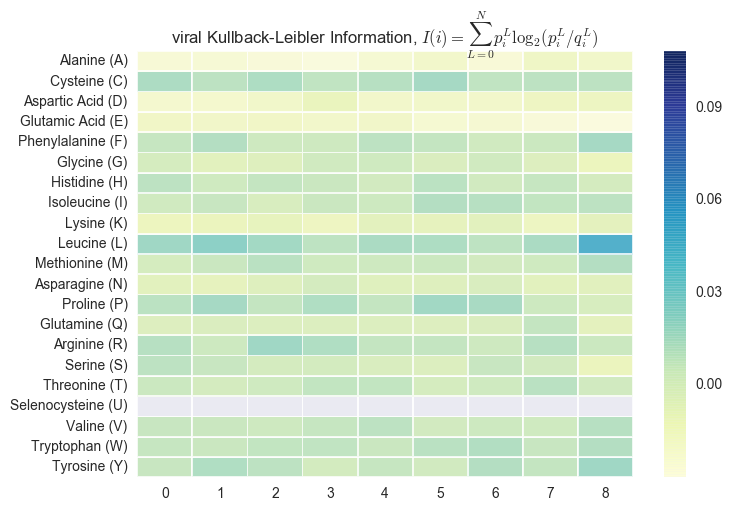

In [12]:
%matplotlib inline
generate_kl_heatmap("viral")

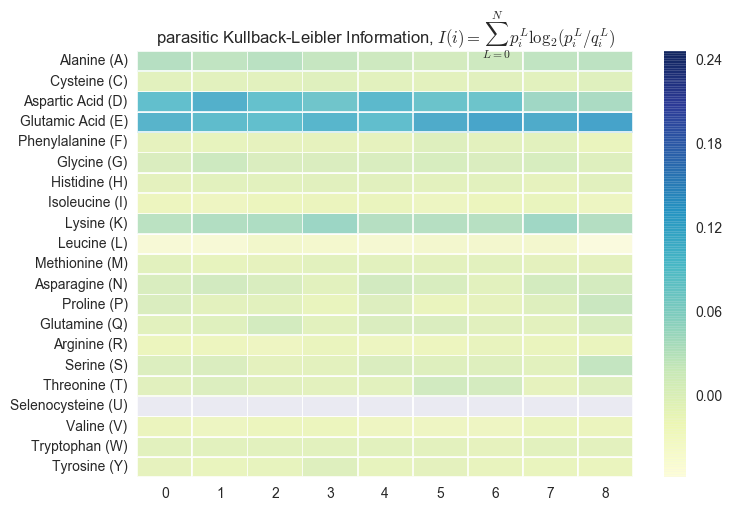

In [13]:
%matplotlib inline
generate_kl_heatmap("parasitic")